In [1]:
!sudo update-alternatives --config python3


There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.12   2         auto mode
  1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.10 to provide /usr/bin/python3 (python3) in manual mode


In [2]:
!python3 -m pip install --upgrade pip
!python3 -m pip install "gymnasium[atari]" ale-py autorom


/usr/bin/python3: No module named pip
/usr/bin/python3: No module named pip


In [3]:
!which python3
!python3 --version


/usr/bin/python3
Python 3.10.12


In [4]:
!wget https://bootstrap.pypa.io/get-pip.py
!python3 get-pip.py


--2025-12-03 04:24:32--  https://bootstrap.pypa.io/get-pip.py
Resolving bootstrap.pypa.io (bootstrap.pypa.io)... 151.101.0.175, 151.101.64.175, 151.101.128.175, ...
Connecting to bootstrap.pypa.io (bootstrap.pypa.io)|151.101.0.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182415 (2.1M) [text/x-python]
Saving to: ‘get-pip.py’

get-pip.py          100%[===================>]   2.08M  --.-KB/s    in 0.03s   

2025-12-03 04:24:32 (78.6 MB/s) - ‘get-pip.py’ saved [2182415/2182415]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pip]


In [5]:
!python3 -m pip --version

pip 25.3 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [6]:
!python3 -m pip install "gymnasium[atari]==0.29.1"
!python3 -m pip install "ale-py==0.8.1"
!python3 -m pip install autorom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [shimmy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [autorom]


In [7]:
!python3 -m pip install "gymnasium[atari]" ale-py AutoROM AutoROM.accept-rom-license

!python3 -m AutoROM.accept_rom_license --accept-license


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=f1ac67279c26702dfa43f6079a27c442f3ab1700f77894ea03e0a4db8e5cb065
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
/usr/bin/python3: No module named AutoROM.accept_rom_license


In [8]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)
print("Atari envs registered!")

gym.pprint_registry()


Atari envs registered!
===== classic_control =====
Acrobot-v1                  CartPole-v0                 CartPole-v1
MountainCar-v0              MountainCarContinuous-v0    Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0          phys2d/CartPole-v1          phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3            BipedalWalkerHardcore-v3    CarRacing-v3
LunarLander-v3              LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1                CliffWalking-v1             CliffWalkingSlippery-v1
FrozenLake-v1               FrozenLake8x8-v1            Taxi-v3
===== tabular =====
tabular/Blackjack-v0        tabular/CliffWalking-v0
===== None =====
Ant-v2                      Ant-v3                      GymV21Environment-v0
GymV26Environment-v0        HalfCheetah-v2              HalfCheetah-v3
Hopper-v2                   Hopper-v3                   Humanoid-v2
Humanoid-v3                 HumanoidStandup-v2          InvertedDoublePendulum-v2
InvertedPendulum-v2        

In [10]:
import gymnasium as gym
import ale_py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque

gym.register_envs(ale_py)


#  Frame Stack

class LazyFrames:
    def __init__(self, frames):
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        return out.astype(dtype) if dtype else out


class FrameStack:
    def __init__(self, env, k=4):
        self.env = env
        self.k = k
        self.frames = deque(maxlen=k)

        # Forward action space
        self.action_space = env.action_space

        # observation space
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, 84, 84), dtype=np.uint8
        )

    def reset(self):
        obs, info = self.env.reset()
        obs = np.expand_dims(obs, 0)

        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(obs)

        return LazyFrames(list(self.frames)), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = np.expand_dims(obs, 0)
        self.frames.append(obs)

        return LazyFrames(list(self.frames)), reward, terminated, truncated, info




#Atari Environment

def make_env():
    env = gym.make("ALE/SpaceInvaders-v5", frameskip=1)

    env = gym.wrappers.AtariPreprocessing(
        env,
        grayscale_obs=True,
        frame_skip=4,
        screen_size=84
    )

    env = FrameStack(env, k=4)
    return env


# CNN

class DQN(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.fc = nn.Linear(32 * 9 * 9, 256)
        self.out = nn.Linear(256, action_dim)

    def forward(self, x):
        x = x / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc(x))
        return self.out(x)


#Replay Buffer

class ReplayBuffer:
    def __init__(self, size=100_000):
        self.buffer = deque(maxlen=size)

    def add(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))

    def sample(self, batch):
        s, a, r, ns, d = zip(*random.sample(self.buffer, batch))
        return (
            np.array([np.array(x) for x in s], dtype=np.uint8),
            np.array(a),
            np.array(r),
            np.array([np.array(x) for x in ns], dtype=np.uint8),
            np.array(d),
        )

    def __len__(self):
        return len(self.buffer)


#DQN Agent

class Agent:
    def __init__(self):
        self.env = make_env()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        self.n_actions = self.env.action_space.n

        self.policy = DQN(self.n_actions).to(self.device)
        self.target = DQN(self.n_actions).to(self.device)
        self.target.load_state_dict(self.policy.state_dict())

        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-4)
        self.buffer = ReplayBuffer()

        self.gamma = 0.99
        self.batch = 32
        self.update_target_every = 2000
        self.train_start = 10_000

        # Epsilon-greedy
        self.eps = 1.0
        self.eps_min = 0.05
        self.eps_decay = 400_000
        self.step = 0


    def act(self, state):
        self.step += 1
        self.eps = max(self.eps_min, 1 - self.step / self.eps_decay)

        if random.random() < self.eps:
            return random.randint(0, self.n_actions - 1)

        s = torch.tensor(np.array(state), dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy(s)).item()

    def train_step(self):
        if len(self.buffer) < self.train_start:
            return

        s, a, r, ns, d = self.buffer.sample(self.batch)

        s = torch.tensor(s, dtype=torch.float32, device=self.device)
        ns = torch.tensor(ns, dtype=torch.float32, device=self.device)
        a = torch.tensor(a, device=self.device).unsqueeze(1)
        r = torch.tensor(r, dtype=torch.float32, device=self.device).unsqueeze(1)
        d = torch.tensor(d, dtype=torch.float32, device=self.device).unsqueeze(1)

        #  Q(s,a)
        q = self.policy(s).gather(1, a)

        # target
        with torch.no_grad():
            next_q = self.target(ns).max(1)[0].unsqueeze(1)
            target = r + self.gamma * next_q * (1 - d)

        loss = F.smooth_l1_loss(q, target)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 5)
        self.optimizer.step()

        # Update target network
        if self.step % self.update_target_every == 0:
            self.target.load_state_dict(self.policy.state_dict())
            print("Target updated at step", self.step)

    def train(self, episodes=1000):
        for ep in range(1, episodes + 1):
            s, _ = self.env.reset()
            total_reward = 0

            for _ in range(8000):
                a = self.act(s)
                ns, r, terminated, truncated, _ = self.env.step(a)


                r = np.sign(r)

                self.buffer.add(s, a, r, ns, terminated)
                self.train_step()

                s = ns
                total_reward += r

                if terminated or truncated:
                    break

            print(f"Episode {ep} | Reward: {total_reward} | Epsilon {self.eps:.3f}")



# TRAINING

agent = Agent()
agent.train(episodes=1000)


Episode 1 | Reward: 11.0 | Epsilon 0.998
Episode 2 | Reward: 9.0 | Epsilon 0.997
Episode 3 | Reward: 16.0 | Epsilon 0.995
Episode 4 | Reward: 8.0 | Epsilon 0.994
Episode 5 | Reward: 8.0 | Epsilon 0.993
Episode 6 | Reward: 9.0 | Epsilon 0.992
Episode 7 | Reward: 10.0 | Epsilon 0.991
Episode 8 | Reward: 6.0 | Epsilon 0.990
Episode 9 | Reward: 8.0 | Epsilon 0.989
Episode 10 | Reward: 4.0 | Epsilon 0.988
Episode 11 | Reward: 8.0 | Epsilon 0.987
Episode 12 | Reward: 3.0 | Epsilon 0.986
Episode 13 | Reward: 5.0 | Epsilon 0.985
Episode 14 | Reward: 5.0 | Epsilon 0.984
Episode 15 | Reward: 5.0 | Epsilon 0.983
Episode 16 | Reward: 15.0 | Epsilon 0.981
Episode 17 | Reward: 5.0 | Epsilon 0.981
Episode 18 | Reward: 7.0 | Epsilon 0.980
Episode 19 | Reward: 4.0 | Epsilon 0.979
Episode 20 | Reward: 15.0 | Epsilon 0.977
Episode 21 | Reward: 7.0 | Epsilon 0.976
Target updated at step 10000
Episode 22 | Reward: 4.0 | Epsilon 0.975
Episode 23 | Reward: 3.0 | Epsilon 0.974
Episode 24 | Reward: 3.0 | Epsil

In [11]:
torch.save(agent.policy.state_dict(), "SpaceInvaders_dqn.pth")

Parsed episodes: 1000


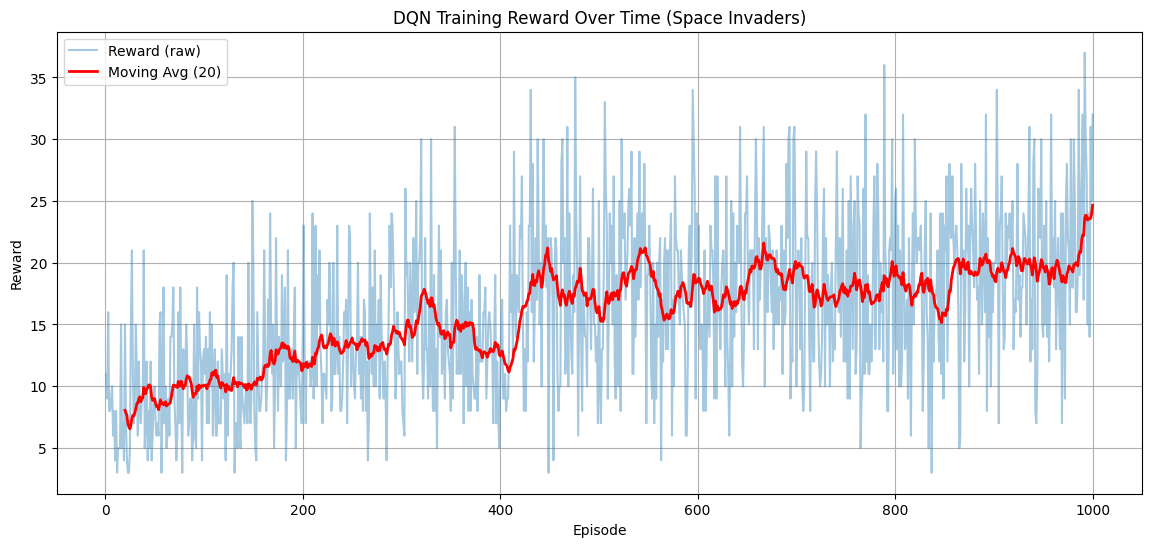

In [1]:
import re
import matplotlib.pyplot as plt

# Load file
log_path = "/content/space_invaders_dqn_results.txt"
with open(log_path, "r") as f:
    lines = f.readlines()

episodes = []
rewards = []


pattern = r"Episode\s+(\d+)\s*\|\s*Reward:\s*(-?\d+\.?\d*)"

for line in lines:
    match = re.search(pattern, line)
    if match:
        ep = int(match.group(1))
        rew = float(match.group(2))
        episodes.append(ep)
        rewards.append(rew)

print("Parsed episodes:", len(episodes))

# Plot
plt.figure(figsize=(14,6))
plt.plot(episodes, rewards, alpha=0.4, label="Reward (raw)")

# Moving average smoothing
import numpy as np
window = 20
if len(rewards) >= window:
    smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(episodes[window-1:], smooth, color='red', linewidth=2, label=f"Moving Avg ({window})")

plt.title("DQN Training Reward Over Time (Space Invaders)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = DQN(action_dim=6).to(device)

MODEL_PATH = "/content/SpaceInvaders_dqn.pth"

policy.load_state_dict(torch.load(MODEL_PATH, map_location=device))
policy.eval()

print("Model loaded!")


Model loaded!


In [20]:
import gymnasium as gym
import ale_py
import numpy as np
import torch
from collections import deque
from gymnasium.wrappers import RecordVideo

gym.register_envs(ale_py)


class LazyFrames:
    def __init__(self, frames):
        self._frames = frames
    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype:
            out = out.astype(dtype)
        return out

class FrameStack:
    def __init__(self, env, k=4):
        self.env = env
        self.k = k
        self.frames = deque(maxlen=k)

    def reset(self):
        obs, info = self.env.reset()
        processed = np.expand_dims(obs, 0)
        for _ in range(self.k):
            self.frames.append(processed)
        return LazyFrames(list(self.frames)), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = np.expand_dims(obs, 0)
        self.frames.append(obs)
        return LazyFrames(list(self.frames)), reward, terminated, truncated, info

    def close(self):
        if hasattr(self.env, "close"):
            self.env.close()

# Evaluation Environment for Space Invaders

def make_eval_env():

    env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")

    env = gym.wrappers.AtariPreprocessing(
        env,
        grayscale_obs=True,
        frame_skip=1,
        screen_size=84
    )


    env = RecordVideo(
        env,
        video_folder="/content/spaceinvaders_eval/",
        episode_trigger=lambda ep: True
    )


    env = FrameStack(env, k=4)

    return env



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


env = make_eval_env()
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    s = torch.tensor(np.array(obs), dtype=torch.float32, device=device).unsqueeze(0)

    with torch.no_grad():
        action = torch.argmax(policy(s)).item()

    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward

print("Episode reward:", total_reward)

env.close()


Episode reward: 770.0


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
